In [1]:
!pip install tensorflow opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!pip list

Package                      Version   Editable project location
---------------------------- --------- -------------------------
absl-py                      2.0.0
altair                       5.1.2
ansi2html                    1.8.0
anyio                        3.6.2
appdirs                      1.4.4
argon2-cffi                  21.3.0
argon2-cffi-bindings         21.2.0
arrow                        1.2.3
asttokens                    2.2.1
astunparse                   1.6.3
attrs                        23.1.0
backcall                     0.2.0
beautifulsoup4               4.12.2
bleach                       6.0.0
blinker                      1.6.2
Brotli                       1.0.9
bs4                          0.0.1
cachetools                   5.3.1
caer                         2.0.8
catboost                     1.2
certifi                      2022.12.7
cffi                         1.15.1
charset-normalizer           3.1.0
click                        8.1.3
colorama               

In [3]:
import os
import tensorflow as tf

In [5]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus

[]

In [6]:
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [7]:
tf.config.list_physical_devices('GPU')

[]

Remove Dodgy Images

In [10]:
import cv2
import imghdr #To check file extensions

In [14]:
data_dir = 'data'
extensions = ['jpeg','jpg','png','bmp']

for folder in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir,folder)):
        path = os.path.join(data_dir,folder,image)
        
        try:
            img = cv2.imread(path)   # To check file is valid image or not by opening it
            ext = imghdr.what(path)
            
            if ext not in extensions:
                print("{} not in extension list".format(path)) 
                os.remove(path)
        except Exception as e:
            print('Issue with image {}'.format(path))            

Load DataSet

In [13]:
import numpy as np
from matplotlib import pyplot as plt

<b>To see Defualt parameters</b>
tf.keras.utils.image_dataset_from_directory??
<br>
<b>To change Defualt parameters</b>
tf.keras.utils.image_dataset_from_directory('data',batch_size=8,image_size=(224,224))

In [37]:
data = tf.keras.utils.image_dataset_from_directory('data') 

Found 305 files belonging to 2 classes.


In [16]:
data_iterator = data.as_numpy_iterator()

In [28]:
# Useful To change data from batch
batch = data_iterator.next()

In [25]:
len(batch)  # ans is 2 ==> 1]images as aarray and 2]labels for classes(0 or 1) 
# Here 0  = Happy and  1 = Sad

2

In [29]:
# batch[0]
print(len(batch[0]))  #This is mention in defualt batch_size in tf.keras.utils.img_data....
print(batch[1])
batch[0].shape

32
[1 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 1 1 0 1 0]


(32, 256, 256, 3)

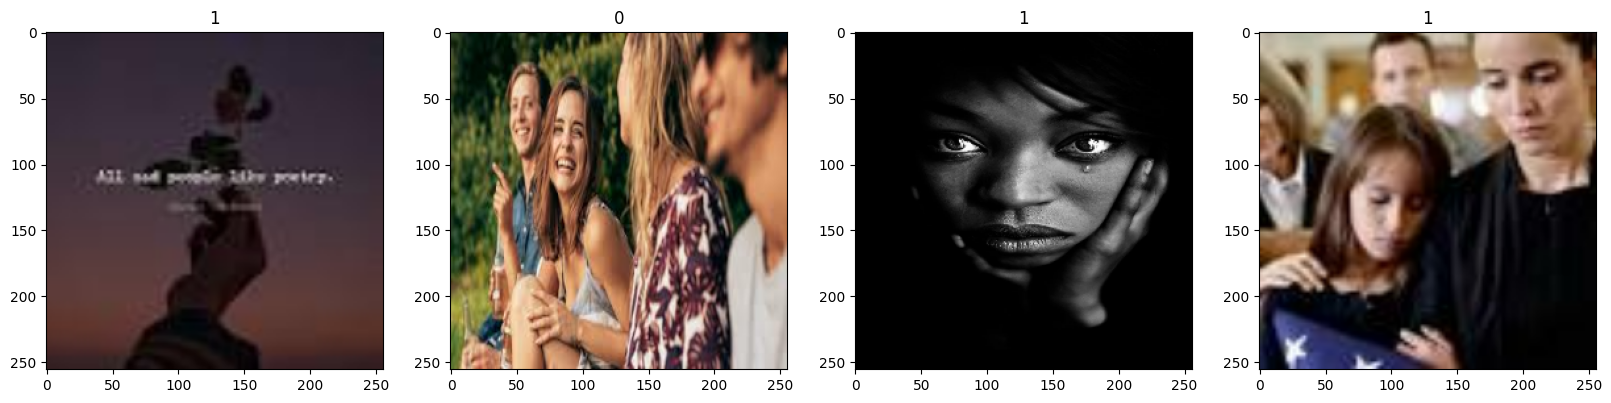

In [30]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])               
    

Data PreProcessing

In [38]:
data = data.map(lambda x,y: (x/255,y))

In [40]:
scaled_iterator = data.as_numpy_iterator()

In [41]:
batch = scaled_iterator.next()

In [42]:
batch[0].max()

1.0

Split Data

In [43]:
len(data)  #no of batches

10

In [44]:
train_size = int(len(data)* .7)
val_size = int(len(data)* .2)
test_size = int(len(data)* .1)

In [46]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

In [48]:
print(len(train))
print(len(val))
print(len(test))

7
2
1


Model Building


In [58]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

In [59]:
model = Sequential()

In [60]:
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16, (3,3), activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [62]:
model.compile('adam', loss = tf.losses.BinaryCrossentropy(), metrics = ['accuracy'])

In [63]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 30, 30, 16)       

Model Training

In [64]:
log_dir = 'log'

In [66]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)

In [67]:
hist = model.fit(train, epochs=20, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/20


7/7 [==============================] - 12s 804ms/step - loss: 1.1452 - accuracy: 0.4643 - val_loss: 0.7276 - val_accuracy: 0.3594
Epoch 2/20
7/7 [==============================] - 7s 706ms/step - loss: 0.6917 - accuracy: 0.5670 - val_loss: 0.6885 - val_accuracy: 0.5781
Epoch 3/20
7/7 [==============================] - 7s 732ms/step - loss: 0.6809 - accuracy: 0.6116 - val_loss: 0.6401 - val_accuracy: 0.7656
Epoch 4/20
7/7 [==============================] - 7s 691ms/step - loss: 0.6218 - accuracy: 0.7188 - val_loss: 0.5980 - val_accuracy: 0.7031
Epoch 5/20
7/7 [==============================] - 7s 728ms/step - loss: 0.5145 - accuracy: 0.8036 - val_loss: 0.4042 - val_accuracy: 0.8281
Epoch 6/20
7/7 [==============================] - 7s 695ms/step - loss: 0.4348 - accuracy: 0.8259 - val_loss: 0.3593 - val_accuracy: 0.8438
Epoch 7/20
7/7 [==============================] - 7s 701ms/step - loss: 0.3366 - accuracy: 0.8795 - val_loss: 0.2663 - val_accuracy: 0.9219
Epoch 8/20
7/7 [=

In [70]:
# hist
# hist.history

Plotting

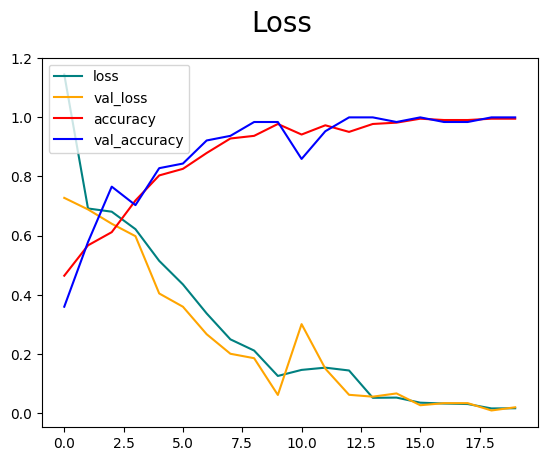

In [76]:
fig = plt.figure()
plt.plot(hist.history['loss'], color = 'teal', label = 'loss')
plt.plot(hist.history['val_loss'], color = 'orange', label = 'val_loss')
plt.plot(hist.history['accuracy'], color = 'red', label = 'accuracy')
plt.plot(hist.history['val_accuracy'], color = 'blue', label = 'val_accuracy')
fig.suptitle('Loss',fontsize = 20)
plt.legend(loc = 'upper left')
plt.show()

Performance Evaluation 

In [80]:
from keras.metrics import Precision, Recall, BinaryAccuracy

In [83]:
p = Precision()
r = Recall()
b = BinaryAccuracy()

In [84]:
for batch in test.as_numpy_iterator():
    x,y = batch
    y_hat = model.predict(x)
    p.update_state(y,y_hat)
    r.update_state(y,y_hat)
    b.update_state(y,y_hat)

1/1 [==============================] - 1s 689ms/step


In [85]:
print(f'Precision : {p.result().numpy()} ; Recall : {r.result().numpy()} ; Accuracy : {b.result().numpy()}')

Precision : 1.0 ; Recall : 1.0 ; Accuracy : 1.0


Testing

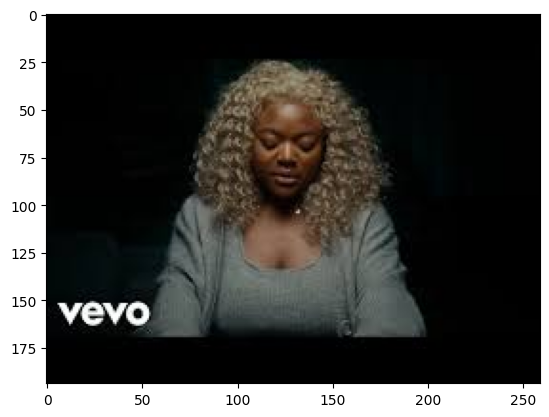

In [107]:
img = cv2.imread('s.jpeg')
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

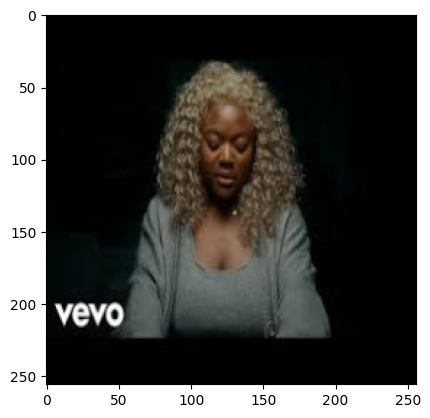

In [108]:
resize = tf.image.resize(img_rgb,(256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [109]:
y_hat = model.predict(np.expand_dims(resize/255,0)) # as model expecting batch of images we use np.expand_dims to put image in array

1/1 [==============================] - 0s 37ms/step


In [110]:
y_hat

array([[0.9999955]], dtype=float32)

Saving

In [112]:
from keras.models import load_model

In [114]:
model.save(os.path.join('models','HAPPY_or_SAD.h5'))